
# Step 0.2: Clean up the Yelp dataset

This notebook cleans up the yelp dataset and converts the JSON files into tidy tabular data in CSV format.

The steps we have taken:

- The nested JSON objects about business categories and attributes are flattened as separate columns.
- Each business is assigned a neighborhood and a census tract using spatial joins.
- Businesses are pruned to be only those within known neighborhoods.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.io.json import json_normalize

sns.set(
    style="white",
    color_codes=True,
    rc={
        'axes.linewidth': 0.5,
        'lines.linewidth': 2,
        'axes.labelsize': 14,
        'axes.titlesize': 14
    }
)

pd.set_option('display.max_rows', 3)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Businesses

### Load data

In [2]:
business_path = '../../../yelp-data/business.json'
business_json = [json.loads(line) for line in open(business_path)]
business_df = pd.DataFrame(business_json)
business_df

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,691 Richmond Rd,"{'RestaurantsPriceRange2': 2, 'BusinessParking...",YDf95gJZaq05wvo7hTQbbQ,"[Shopping, Shopping Centers]",Richmond Heights,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,41.541716,-81.493116,Richmond Town Square,,44143,17,2.0,OH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156638,540 Marks St,"{'BusinessAcceptsCreditCards': True, 'Restaura...",scMIE4jyGp7FkWrMKAgjxA,"[Fashion, Shopping, Food, Department Stores, M...",Henderson,{},0,36.060708,-115.033241,Walmart,,89014,42,2.5,NV


### Categories

First, let's check what are the top categories.

In [3]:
from collections import Counter

cat_count = Counter(json_normalize(business_json, ['categories'])[0].values)
cat_count = pd.DataFrame(cat_count.most_common(), columns=['category', 'count'])
display(cat_count)

,category,count
0,Restaurants,51613
...,...,...
1239,EV Charging Stations,1


Following graph shows the distribution of business count among all 1240 categories.

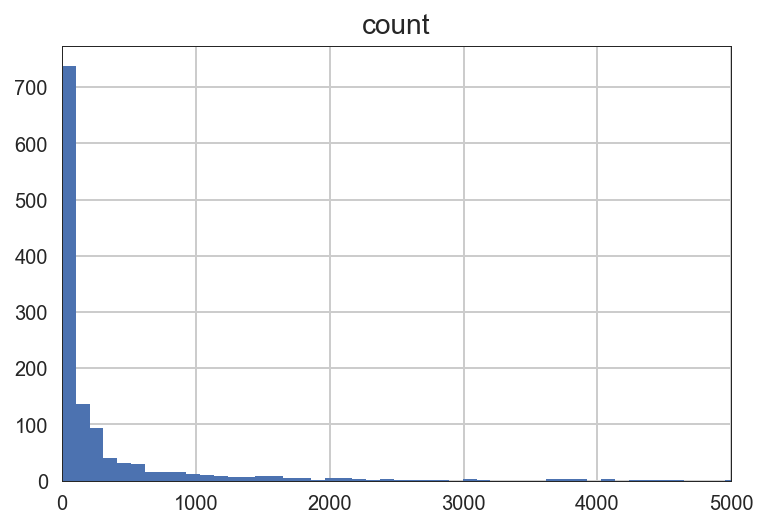

In [4]:
cat_count.hist(bins=500)
_ = plt.xlim([0, 5000])

More than half (700+) categories have less than 10 businesses. We would only want to keep the most popular ones.

A business may be tagged with multiple hierarchical categories, we add an additional column to businesses, indicating their root-level category.

In [5]:
# All Yelp categories, downloaded from https://www.yelp.com/developers/documentation/v3/category_list
categories = json.loads(open('../data/step0/categories.json').read())

id2cat = {
    x['alias']: x
    for x in categories
}

def cat_level(x, level=0):
    if len(x['parents']) == 0:
        return level + 1
    for parent in x['parents']:
        parent = id2cat[parent]
        return cat_level(parent, level + 1)
    
# The root categories
root_categories = [x['title'] for x in categories if len(x['parents']) == 0]
second_level_categories = [x['title'] for x in categories if cat_level(x) < 3]

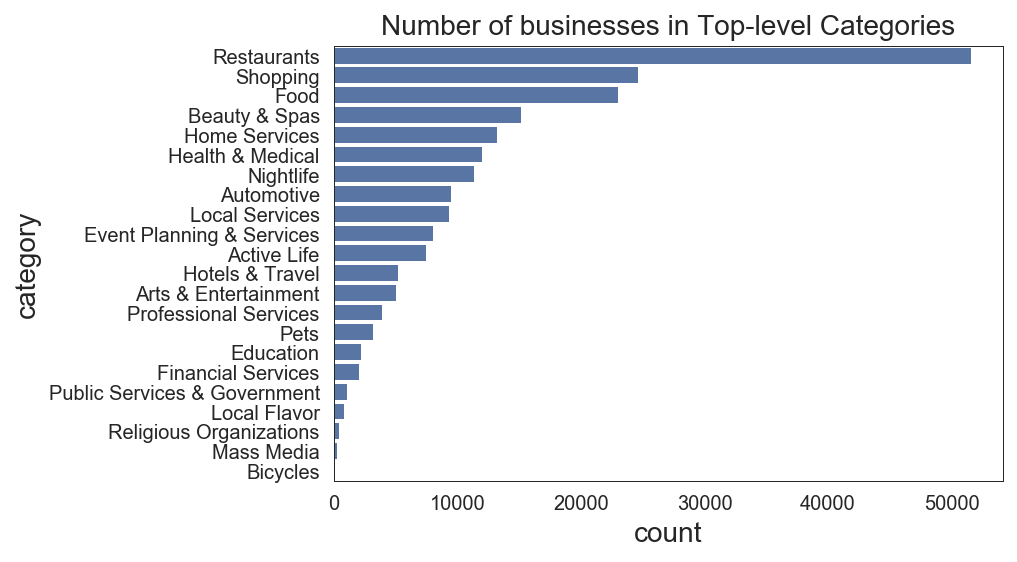

In [6]:
root_cat_count = cat_count[cat_count['category'].isin(root_categories)]
g = sns.categorical.barplot(
    y='category',
    x='count',
    color='b',
    data=root_cat_count)
g.set_title('Number of businesses in Top-level Categories')

In [7]:
# First set the root categories of businesses
root_cats = set(root_cat_count['category'][:13])  # Till "Arts & Entertainment"
biz_cats = [
    {item: True for item in set(x['categories']) & root_cats}
    for x in business_json
]
biz_cats = json_normalize(biz_cats)
biz_cats

,Active Life,Arts & Entertainment,Automotive,Beauty & Spas,Event Planning & Services,Food,Health & Medical,Home Services,Hotels & Travel,Local Services,Nightlife,Restaurants,Shopping
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
156638,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True


In [8]:
# drop both categories and attributes column
biz_df = pd.concat([business_df.drop(['categories', 'attributes'], axis=1), biz_cats], axis=1)
biz_df

,address,business_id,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,...,Beauty & Spas,Event Planning & Services,Food,Health & Medical,Home Services,Hotels & Travel,Local Services,Nightlife,Restaurants,Shopping
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,Richmond Heights,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,41.541716,-81.493116,Richmond Town Square,,44143,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156638,540 Marks St,scMIE4jyGp7FkWrMKAgjxA,Henderson,{},0,36.060708,-115.033241,Walmart,,89014,...,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True


### Attributes

Attributes are amenities or extra services businesses provide, are often telling of how "upscale" a business is. We suspect most attributes are only available to restaurants, as Yelp is regarded as mostly a review website for restaurants. Let's verify whether that is true.

In [9]:
biz_attrs = json_normalize(business_df.to_dict('list'), ['attributes'])

# proportion of businesses with the attribute set
top_attrs = biz_attrs.isnull().agg('mean').sort_values()

print('Total number of attributes: {}'.format(len(top_attrs)))

pd.set_option('display.max_rows', 50)
display(top_attrs)
pd.set_option('display.max_rows', 3)

Total number of attributes: 39


BusinessAcceptsCreditCards    0.229113
RestaurantsPriceRange2        0.384859
BusinessParking               0.429012
BikeParking                   0.530768
GoodForKids                   0.627411
RestaurantsTakeOut            0.651121
OutdoorSeating                0.678816
RestaurantsGoodForGroups      0.683170
RestaurantsDelivery           0.701205
RestaurantsReservations       0.702992
RestaurantsAttire             0.713909
Alcohol                       0.717567
WheelchairAccessible          0.718952
HasTV                         0.720836
WiFi                          0.722745
GoodForMeal                   0.725790
Ambience                      0.726122
NoiseLevel                    0.740467
RestaurantsTableService       0.744885
ByAppointmentOnly             0.777942
Caters                        0.779538
DogsAllowed                   0.928409
BusinessAcceptsBitcoin        0.943335
AcceptsInsurance              0.945250
GoodForDancing                0.945524
HappyHour                

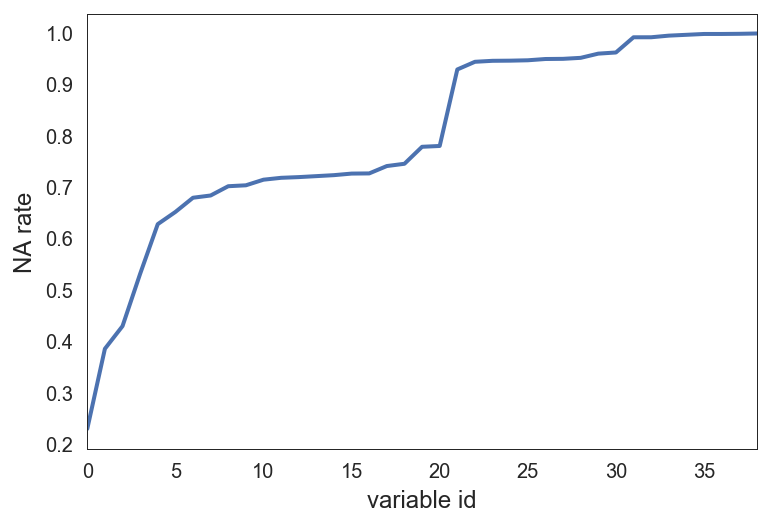

In [10]:
g = top_attrs.plot.line()
g.set_xticklabels(range(0, len(top_attrs), 5))
g.set_xlabel('variable id', size=12)
g.set_ylabel('NA rate', size=12)

Above series displays the proportion of businesses that do not have this attribute set.
We would pick only the top attributes, and attach them to the business data frame.

In [11]:
useful_attrs = [
    'BusinessAcceptsCreditCards',
    'RestaurantsPriceRange2',
    'BikeParking',
    'GoodForKids',
    'RestaurantsTakeOut',
    'OutdoorSeating',
    'RestaurantsGoodForGroups',
    'RestaurantsAttire',
    'GoodForMeal',
    'Ambience',
    'Alcohol'
]

# add attributes as columns
for attr_name in useful_attrs:
    biz_df[attr_name] = biz_attrs[attr_name]
biz_df

,address,business_id,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,...,RestaurantsPriceRange2,BikeParking,GoodForKids,RestaurantsTakeOut,OutdoorSeating,RestaurantsGoodForGroups,RestaurantsAttire,GoodForMeal,Ambience,Alcohol
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,Richmond Heights,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,41.541716,-81.493116,Richmond Town Square,,44143,...,2.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156638,540 Marks St,scMIE4jyGp7FkWrMKAgjxA,Henderson,{},0,36.060708,-115.033241,Walmart,,89014,...,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Pruning

The Yelp dataset has businesses from 1,010 different cities (including duplicate city names due to spelling inconsistencies). It would be impracticable to collect neighborhood characteristics data for all of these citiess. Since more than 70% of the businesses are located in the US, we will focus on US cities only.

Since geographical boundaries data are distributed by states, and some metropolitan areas may encompass multiple cities---both large and small ones, we are filtering the businesses by selecting top states with most businesses, instead of top cities.

In [12]:
pd.set_option('display.max_rows', 15)

# Top 15 states with most businesses
display(biz_df['state'].value_counts()[:15])
pd.set_option('display.max_rows', 2)

AZ     47376
NV     30571
ON     26520
NC     11299
OH     10930
PA      8916
QC      7273
WI      4190
EDH     3561
BW      3071
IL      1667
SC       583
MLN      185
HLD      175
FIF       73
Name: state, dtype: int64

The top US states with most businesses are AZ, NV, NC, OH, PA, WI, IL, SC. Since some records may have incorrect state information set, but it is relatively rare to have incorrect geolocation recorded, we used neighborhood boundaries of aforementioned states and spatial join to filter businesses, instead of filtering them by the `state` column.

### Prune businesses by neighborhoods

Following is the combined GeoDataFrame of the neighborhood boundaries of all 8 states (See `0.2_GeoSpatial.ipynb`).

In [13]:
import geopandas as gpd

nbh = gpd.read_file('../data/step0/zillow-neighborhoods-all')

In [95]:
from shapely.geometry import Point

def to_geo_df(df, crs=None):
    """
    Convert a DF with longitude/latitude to a geo data frame.
    """
    df = df[df['longitude'].notnull()]
    points = [Point((x['longitude'], x['latitude'])) for x in df.to_records('list')]
    df = df.drop(['longitude', 'latitude'], axis=1)
    # CRS is the parameter for projection method
    return gpd.GeoDataFrame(df, crs=crs, geometry=points)
    
biz_geo_df = to_geo_df(biz_df, nbh.crs)
biz_geo_df

,address,business_id,city,hours,is_open,name,neighborhood,postal_code,review_count,stars,...,BikeParking,GoodForKids,RestaurantsTakeOut,OutdoorSeating,RestaurantsGoodForGroups,RestaurantsAttire,GoodForMeal,Ambience,Alcohol,geometry
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,Richmond Heights,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,Richmond Town Square,,44143,17,2.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-81.4931165 41.5417162)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156638,540 Marks St,scMIE4jyGp7FkWrMKAgjxA,Henderson,{},0,Walmart,,89014,42,2.5,...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-115.0332406 36.0607079)


The full dataset has 156,638 businesses with geo-coordinates set, we use spatial join to filter out those in the known neighborhoods of our selected states.

In [97]:
biz_with_nbh = gpd.sjoin(biz_geo_df, nbh, how="inner", op='intersects')

# Titled columns are from Zillow neighborhoods,
# columns with all small cases are from Yelp businesses
# remove geo columns from the Yelp data, because we trust Zillow neighborhoods more
biz_with_nbh = biz_with_nbh.drop(['state','city', 'neighborhood', 'index_right'], axis=1)

biz_with_nbh

,address,business_id,hours,is_open,name,postal_code,review_count,stars,Active Life,Arts & Entertainment,...,Ambience,Alcohol,geometry,State,County,City,Name,RegionID,Nhood,Nhood_area
1,2824 Milton Rd,mLwM-h2YhXl2NCgdS84_Bw,"{'Monday': '10:00-22:00', 'Tuesday': '10:00-22...",0,South Florida Style Chicken & Ribs,28215,4,4.5,NaN,NaN,...,"{'romantic': False, 'intimate': False, 'classy...",NaN,POINT (-80.7419759 35.23687),NC,Mecklenburg,Charlotte,Oak Forest,274830,"Oak Forest, Charlotte, NC",3.580327e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154973,310 N Cottonwood Dr,5vU5jW8cOA0EM4ti9Bm-sg,"{'Monday': '8:00-18:00', 'Tuesday': '8:00-18:0...",1,Home Dog Training Positively,85234,4,5.0,NaN,NaN,...,NaN,NaN,POINT (-111.7857523 33.3557544),AZ,Maricopa,Gilbert,Stonebridge Lakes,417611,"Stonebridge Lakes, Gilbert, AZ",4.514141e+05


In [98]:
print('Number of neighborhoods: ', biz_with_nbh['Nhood'].unique().size)
print('Number of businesses before reduction:', biz_geo_df.shape[0])
print('Number of businesses after reduction:', biz_with_nbh.shape[0])
print('{} / {} = {:.2%}'.format(
    biz_with_nbh.shape[0], biz_geo_df.shape[0],
    biz_with_nbh.shape[0] / biz_geo_df.shape[0]
))

Number of neighborhoods:  792
Number of businesses before reduction: 156638
Number of businesses after reduction: 71308
71308 / 156638 = 45.52%


After pruning by states and neighborhoods, the number of businesses dropped nearly 55%.
To ensure a fair comparison, we shall be careful with neighborhoods with few businesses, too.
While one may argue these neighorhoods may be residential areas, and should be a legitimate neighborhood type to compare with others, we shall at least put them into a separate group before clustering, so that they would not
stop us from telling neighborhoods with different tyeps of businesses apart.

The distribution of business count by neighborhoods tells us how much should the additional pruning applies.

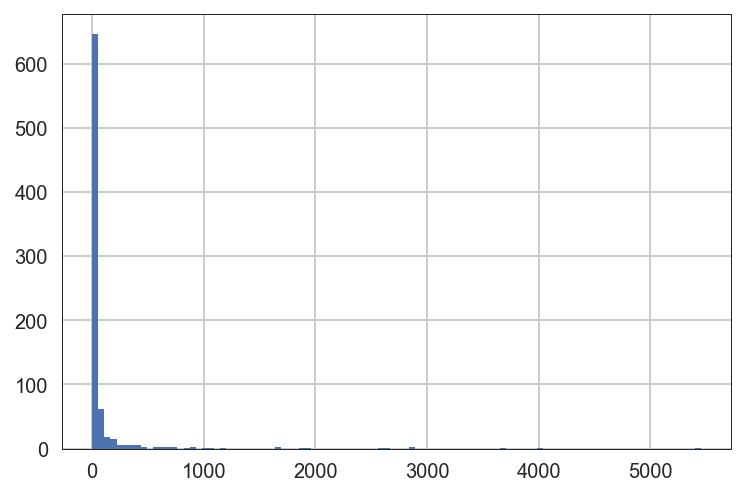

In [99]:
nbh_biz_count = (
    biz_with_nbh.groupby('Nhood')
    .agg({'business_id': ['count']})
    [('business_id', 'count')]
    .sort_values(ascending=False)
)
g = nbh_biz_count.hist(bins=100)

In [100]:
pd.DataFrame(nbh_biz_count.quantile([0, 0.25, 0.5, 0.75, 1])).T

,,0.0,0.25,0.5,0.75,1.0
business_id,count,1.0,3.0,13.0,38.0,5454.0


About half of the neighborhoods have less than 13 businesses. While it may be safe to say those are mostly residential or industrial areas, having no businesses within the neighborhood does not mean they do not have access to businesses nearby. To be more flexible in future analysis, we are assigning each record in the business table the total number of businesses in its neighborhood, instead of excluding these businesses and neighborhoods for good. 

In [101]:
# add neighborhood biz count information for each of filtering
biz_with_nhood =  biz_with_nbh.merge(pd.DataFrame({
    'Nhood': nbh_biz_count.index,
    'Nhood_biz_count': nbh_biz_count.values
}), on='Nhood')

display(biz_with_nhood)

,address,business_id,hours,is_open,name,postal_code,review_count,stars,Active Life,Arts & Entertainment,...,Alcohol,geometry,State,County,City,Name,RegionID,Nhood,Nhood_area,Nhood_biz_count
0,2824 Milton Rd,mLwM-h2YhXl2NCgdS84_Bw,"{'Monday': '10:00-22:00', 'Tuesday': '10:00-22...",0,South Florida Style Chicken & Ribs,28215,4,4.5,NaN,NaN,...,NaN,POINT (-80.7419759 35.23687),NC,Mecklenburg,Charlotte,Oak Forest,274830,"Oak Forest, Charlotte, NC",3.580327e+06,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71307,310 N Cottonwood Dr,5vU5jW8cOA0EM4ti9Bm-sg,"{'Monday': '8:00-18:00', 'Tuesday': '8:00-18:0...",1,Home Dog Training Positively,85234,4,5.0,NaN,NaN,...,NaN,POINT (-111.7857523 33.3557544),AZ,Maricopa,Gilbert,Stonebridge Lakes,417611,"Stonebridge Lakes, Gilbert, AZ",4.514141e+05,1


We can always impose different threshold for business count later when we aggregate measurements by neighborhoods. Following is the number of neighborhoods we can get when applying different thresholds.

In [102]:
thresholds = [0, 5, 10, 20]
for x in thresholds:
    print('business count >= {: <2d}  :  {} neighborhoods'.format(
        x, nbh_biz_count[nbh_biz_count >= x].size
    ))

business count >= 0   :  792 neighborhoods
business count >= 5   :  545 neighborhoods
business count >= 10  :  442 neighborhoods
business count >= 20  :  315 neighborhoods


### Export pruned shapefile for neighborhoods

However, we can at least discard neighborhoods without any business at all.

In [103]:
# neighborhoods with businesses
active_nbhs = biz_with_nbh['Nhood'].unique()
nbh_with_biz = nbh[nbh['Nhood'].isin(active_nbhs)]

print('Total # of neighborhoods:', nbh['Nhood'].unique().size)
print('# of neighborhoods with businesses:', active_nbhs.size)

Total # of neighborhoods: 3353
# of neighborhoods with businesses: 792


In [104]:
display(nbh_with_biz)
nbh_with_biz.to_file('../data/step1/neighborhoods')

,State,County,City,Name,RegionID,Nhood,Nhood_area,geometry
index_right,,,,,,,,
0,AZ,Maricopa,Gilbert,Highland,256336,"Highland, Gilbert, AZ",85807.054247,POLYGON ((-111.7123999999999 33.29793137600003...
...,...,...,...,...,...,...,...,...
3304,WI,Dane,Madison,Park Ridge,343591,"Park Ridge, Madison, WI",122734.946413,POLYGON ((-89.50231126699993 43.04039536700012...


We reduced the 3,353 neighborhoods in 8 states to 792 neighborhoods with at least one business--that's throwing off 77% of the original data. The reason of such drastic reduction is that the Yelp dataset is not complete, and there are a lot of residential neighborhoods naturally would not have many businesses.

Let's zoom in to Las Vegas to see how neighborhood boundaries overlay with the Yelp businesses.

### Prune businesses by census tracts

While it is possible to estimate demographic variables for neighborhoods, by checking how do they overlap with census tracts, it introduces another layer of noises. We might as well simply use census tracts to aggregate measurements for Yelp businesses. To do so, we would need to assign each business a census tract ID, just like we did for the neighborhoods.

In [105]:
tract = gpd.read_file('../data/step0/census-tracts-all')

biz_with_tract = gpd.sjoin(biz_geo_df, tract, how="inner", op='intersects')
biz_with_tract = biz_with_tract.drop(['state','city', 'neighborhood', 'index_right'], axis=1)

biz_with_tract

,address,business_id,hours,is_open,name,postal_code,review_count,stars,Active Life,Arts & Entertainment,...,OutdoorSeating,RestaurantsGoodForGroups,RestaurantsAttire,GoodForMeal,Ambience,Alcohol,geometry,CT_ID,CT_LAND,CT_WATER
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,Richmond Town Square,44143,17,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-81.4931165 41.5417162),39035180102,4183953,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155598,,LPs4gqPdVHt0cYMSWI8TPw,"{'Monday': '7:00-22:00', 'Tuesday': '7:00-22:0...",1,Mr. Electric of Northeast Ohio & Columbus,44070,7,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,POINT (-83.0908883386 40.1735679142),39041011900,8842627,641205


In [106]:
tract_biz_count = (
    biz_with_tract.groupby('CT_ID')
    .agg({'business_id': ['count']})
    [('business_id', 'count')]
    .sort_values(ascending=False)
)
biz_with_ct =  biz_with_tract.merge(pd.DataFrame({
    'CT_ID': tract_biz_count.index,
    'CT_BIZ_COUNT': tract_biz_count.values
}), on='CT_ID')

display(biz_with_ct)

,address,business_id,hours,is_open,name,postal_code,review_count,stars,Active Life,Arts & Entertainment,...,RestaurantsGoodForGroups,RestaurantsAttire,GoodForMeal,Ambience,Alcohol,geometry,CT_ID,CT_LAND,CT_WATER,CT_BIZ_COUNT
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,Richmond Town Square,44143,17,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,POINT (-81.4931165 41.5417162),39035180102,4183953,0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115518,,LPs4gqPdVHt0cYMSWI8TPw,"{'Monday': '7:00-22:00', 'Tuesday': '7:00-22:0...",1,Mr. Electric of Northeast Ohio & Columbus,44070,7,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,POINT (-83.0908883386 40.1735679142),39041011900,8842627,641205,1


### Merge CT and Nhood

In [152]:
biz = (
    biz_geo_df.merge(
        biz_with_ct.loc[:, ['business_id', 'CT_ID', 'CT_LAND', 'CT_WATER', 'CT_BIZ_COUNT']],
        how='outer',
        on='business_id'
    )
    .merge(
        biz_with_nhood.loc[:, ['business_id', 'State', 'County', 'City', 'Name',
                               'Nhood', 'Nhood_area', 'Nhood_biz_count']],
        how='outer',
        on='business_id'
    )
)
biz = biz[biz['CT_ID'].notnull() | biz['Nhood'].notnull()]

display(biz)

,address,business_id,city,hours,is_open,name,neighborhood,postal_code,review_count,stars,...,CT_LAND,CT_WATER,CT_BIZ_COUNT,State,County,City,Name,Nhood,Nhood_area,Nhood_biz_count
0,691 Richmond Rd,YDf95gJZaq05wvo7hTQbbQ,Richmond Heights,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",1,Richmond Town Square,,44143,17,2.0,...,4183953.0,0.0,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156648,540 Marks St,scMIE4jyGp7FkWrMKAgjxA,Henderson,{},0,Walmart,,89014,42,2.5,...,18327522.0,0.0,792.0,NV,Clark,Henderson,Whitney Ranch,"Whitney Ranch, Henderson, NV",7.521403e+06,577.0


In [155]:
# Export ...
biz.to_csv('../data/step1/biz.csv', index=False)

Apparently, all businesses would have census tract ID, but not all of them have an associated neighborhood name. Let's confirm that.

In [153]:
from IPython.core.display import display, HTML

display(HTML('<h5>Businesses with either CT_ID or Nhood</h5>'))
display(biz.shape[0])

display(HTML('<h5>Businesses with CT_ID</h5>'))
display(biz[biz['CT_ID'].notnull()].shape[0])

display(HTML('<h5>Businesses with Nhood</h5>'))
display(biz[biz['Nhood'].notnull()].shape[0])

display(HTML('<h5>Businesses with Nhood but not CT_ID</h5>'))
display(biz[biz['Nhood'].notnull() & biz['CT_ID'].isnull()].shape[0])

115522

115522

71315

0

### Export pruned shapefile for census tracts

In [154]:
active_cts = biz_with_ct['CT_ID'].unique()
tract_with_biz = tract[tract['CT_ID'].isin(active_cts)]

print('Total # of neighborhoods:', tract['CT_ID'].unique().size)
print('# of neighborhoods with businesses:', active_cts.size)

display(tract_with_biz)

# Export ...
tract_with_biz.to_file('../data/step1/census-tracts')

Total # of neighborhoods: 16189
# of neighborhoods with businesses: 2981


,CT_ID,CT_LAND,CT_WATER,geometry
index_right,,,,
5,04021000206,23402094,0,"POLYGON ((-111.582918 33.248961, -111.563251 3..."
...,...,...,...,...
16163,55085970602,361158428,47247008,"POLYGON ((-89.575301 45.764998, -89.571539 45...."


## GeoSpatial Overlays: Las Vegas

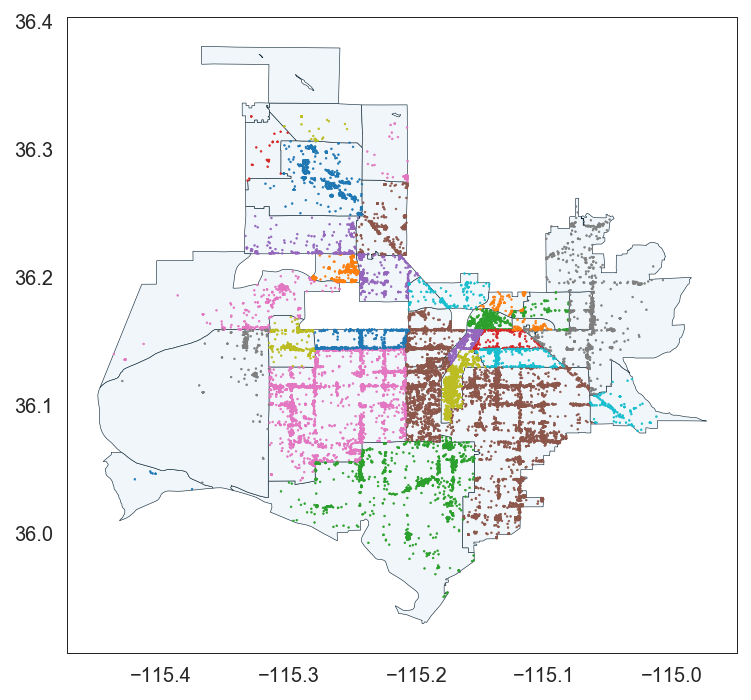

In [22]:
vegas_nbh = nbh[nbh['City'] == 'Las Vegas']
vegas_biz = biz_with_nbh[biz_with_nbh['City'] == 'Las Vegas']

fig, ax = plt.subplots(
    figsize=(6,6),
    subplot_kw={
        'aspect':'equal'
    }
)
g1 = vegas_nbh.plot(color='#f0f6f9', edgecolor='#112939', ax=ax)
g2 = vegas_biz.plot(column='Nhood', markersize=0.8, ax=ax)
# g2.set_title('Businesses and Neighborhood Boundaries in Las Vegas')

###  Add census tracts